# Data source

The common data elements for predictive maintenance problems can be summarized as follows:

* Machine features: The features specific to each individual machine, e.g. engine size, make, model, location, installation date.
* Telemetry data: The operating condition data collected from sensors, e.g. temperature, vibration, operating speeds, pressures.
* Maintenance history: The repair history of a machine, e.g. maintenance activities or component replacements, this can also include error code or runtime message logs.
* Failure history: The failure history of a machine or component of interest.

It is possible that failure history is contained within maintenance history, either as in the form of special error codes or order dates for spare parts. In those cases, failures can be extracted from the maintenance data. Additionally, different business domains may have a variety of other data sources that influence failure patterns which are not listed here exhaustively. These should be identified by consulting the domain experts when building predictive models.

Some examples of above data elements from use cases are:
    
**Machine conditions and usage:** Flight routes and times, sensor data collected from aircraft engines, sensor readings from ATM transactions, train events data, sensor readings from wind turbines, elevators and connected cars.
    
**Machine features:** Circuit breaker technical specifications such as voltage levels, geolocation or car features such as make, model, engine size, tire types, production facility etc.

**Failure history:** fight delay dates, aircraft component failure dates and types, ATM cash withdrawal transaction failures, train/elevator door failures, brake disk replacement order dates, wind turbine failure dates and circuit breaker command failures.

**Maintenance history:** Flight error logs, ATM transaction error logs, train maintenance records including maintenance type, short description etc. and circuit breaker maintenance records.

Given the above data sources, the two main data types we observe in predictive maintenance domain are temporal data and static data. Failure history, machine conditions, repair history, usage history are time series indicated by the timestamp of data collection. Machine and operator specific features, are more static, since they usually describe the technical specifications of machines or operator’s properties.


# Step 1: Data Ingestion

This data aquisiton notebook will download the simulated predicitive maintenance data sets from blob storage. We do some preliminary data cleaning and verification, and store the results as a Spark data frame in cluster for use in the remaining notebook steps of this analysis.

**Note:** This notebook will take less than 3 minutes to execute all cells on a Azure Databricks cluster of type Standard_DS13_v2 cluster, This include the time spent handling the _telemetry_ data set, which contains about 8.7 million records.

In [2]:
import os
import time
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
plt.style.use('ggplot')

# Time the notebook execution. 
# This will only make sense if you "Run all cells"

tic = time.time()

parquet_files_names = {'machines':'machines_files.parquet','maint':'maint_files.parquet',
         'errors': 'errors_files.parquet','telemetry':'telemetry_files.parquet',
        'failures':'failure_files.parquet'}

csv_files_names = {'machines':'machines.csv','maint':'maint.csv',
         'errors': 'errors.csv','telemetry':'telemetry.csv',
        'failures':'failures.csv'}

target_dir = "dbfs:/dataset/"
storage_path = "wasb://predmaintenance@amlgitsamples.blob.core.windows.net/data/"

#dbutils.fs.rm(target_dir, recurse = True)
dbutils.fs.mkdirs(target_dir) 
dbutils.fs.cp(storage_path, target_dir, recurse=True)
display(dbutils.fs.ls(target_dir))

path,name,size
dbfs:/dataset/errors.csv,errors.csv,405509
dbfs:/dataset/errors_files.parquet/,errors_files.parquet/,0
dbfs:/dataset/failure_files.parquet/,failure_files.parquet/,0
dbfs:/dataset/failures.csv,failures.csv,221172
dbfs:/dataset/machines.csv,machines.csv,16435
dbfs:/dataset/machines_files.parquet/,machines_files.parquet/,0
dbfs:/dataset/maint.csv,maint.csv,1039435
dbfs:/dataset/maint_files.parquet/,maint_files.parquet/,0
dbfs:/dataset/telemetry.csv,telemetry.csv,809939545
dbfs:/dataset/telemetry_files.parquet/,telemetry_files.parquet/,0


## Download simulated data sets

The five data files are:

 * machines.csv
 * maint.csv
 * errors.csv
 * telemetry.csv
 * failures.csv

To get an idea of what is contained in the data, we examine this machine schematic. 
![Machine schematic](https://raw.githubusercontent.com/Azure/MachineLearningSamples-PredictiveMaintenance/master/images/machine.png)

There are 1000 machines of four different models. Each machine contains four components of interest, and four sensors measuring voltage, pressure, vibration and rotation. A controller monitors the system and raises alerts for five different error conditions. Maintenance logs indicate when something is done to the machine which does not include a component replacement. A failure is defined by the replacement of a component. 

This notebook does some preliminary data cleanup, creates summary graphics for each data set to verify the data downloaded correctly, and stores the resulting data sets in the cluster storage.

### Machines data set

This simulation tracks a simulated set of 1000 machines over the course of a single year (2015). 

This data set includes information about each machine: Machine ID, model type and age (years in service).

In [5]:
machines =  spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load(os.path.join(storage_path,csv_files_names['machines']))
display(machines.take(5))

machineID,model,age
1,model2,18
2,model4,7
3,model3,8
4,model3,7
5,model2,2


The figure shows how long the collection of machines have been in service. It indicates there are four model types, shown in different colors, and all four models have been in service over the entire 20 years of service. The machine age will be a feature in our analysis, since we expect older machines may have a different set of errors and failures then machines that have not been in service long.

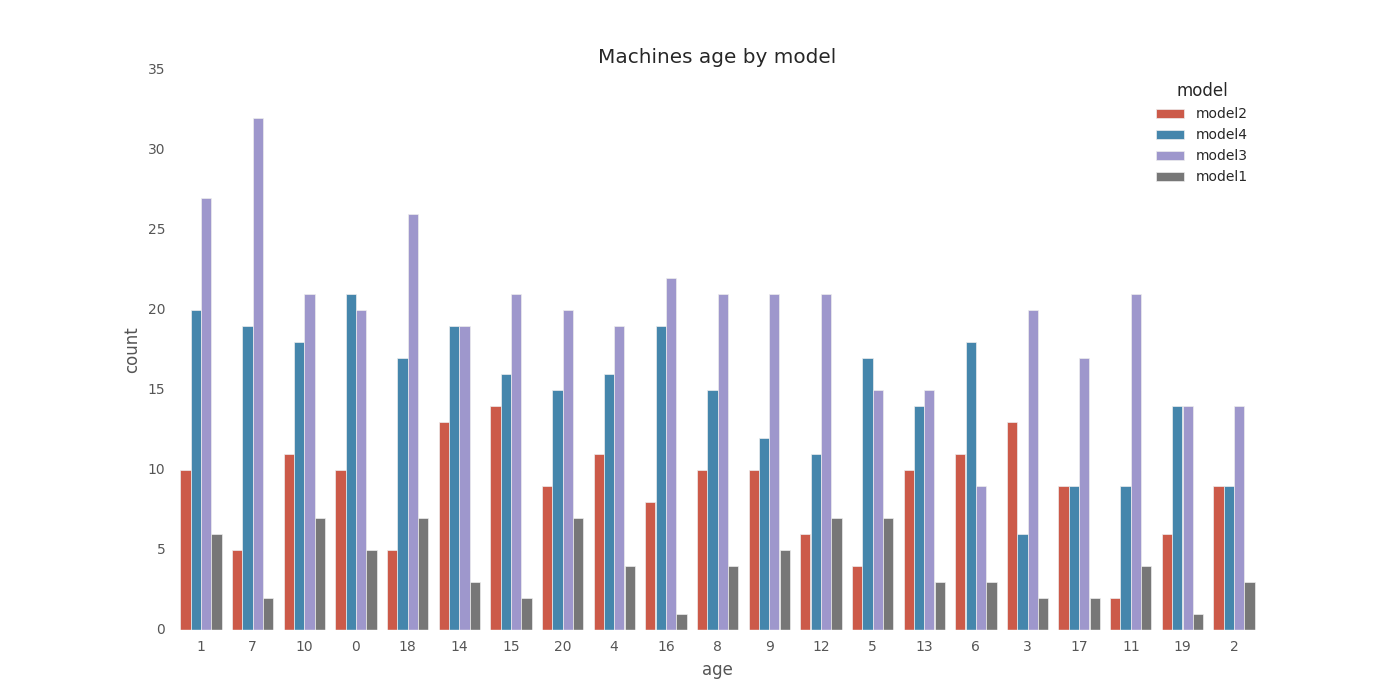

In [7]:
machines_df = machines.toPandas()
plt.figure(figsize=(14, 7))
ax = sns.countplot(x="age", hue="model", data=machines_df,
                   order = machines_df.age.value_counts().index).set_title("Machines age by model")
del machines_df
display(ax.figure)

### Errors  data set

The error log contains non-breaking errors recorded while the machine is still operational. These errors are not considered failures, though they may be predictive of a future failure event. The error datetime field is rounded to the closest hour since the telemetry data (loaded later) is collected on an hourly rate.

In [9]:
errors =  spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load(os.path.join(storage_path,csv_files_names['errors']))
display(errors.take(5))

datetime,machineID,errorID
2015-01-06T03:00:00.000+0000,1,error3
2015-02-03T06:00:00.000+0000,1,error4
2015-02-21T11:00:00.000+0000,1,error1
2015-02-21T16:00:00.000+0000,1,error2
2015-03-20T06:00:00.000+0000,1,error1


The figure shows how many errors occured in each of the five error classes over the entire year. We could split this figure over each individual machine, but with 1000 individuals, the figure would not be very informative.

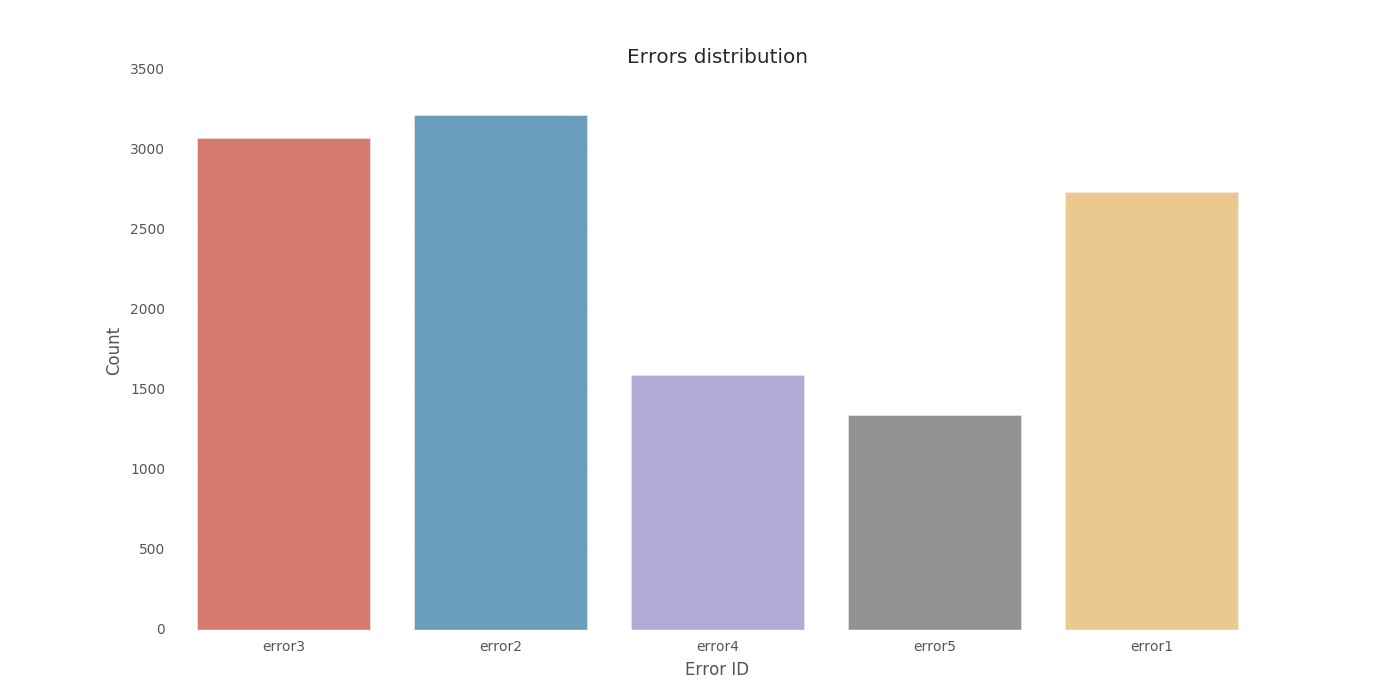

In [11]:
fig, ax = plt.subplots(figsize=(14,7)) 
errors_count = (spark.createDataFrame(errors.groupBy('errorID').count().collect())
              .toPandas())
sns.barplot(errors_count['errorID'], errors_count['count'], alpha=0.8).set_title('Errors distribution')
ax.set_ylabel("Count")
ax.set_xlabel("Error ID")
display(ax.figure)

### Maintenance data set

The maintenance log contains both scheduled and unscheduled maintenance records. Scheduled maintenance corresponds with  regular inspection of components, unscheduled maintenance may arise from mechanical failure or other performance degradations. A failure record is generated for component replacement in the case  of either maintenance events. Because maintenance events can also be used to infer component life, the maintenance data has been collected over two years (2014, 2015) instead of only over the year of interest (2015).

In [13]:
maint=  spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load(os.path.join(storage_path,csv_files_names['maint']))
display(maint.take(5))

datetime,machineID,comp
2014-07-01T06:00:00.000+0000,1,comp4
2014-09-14T06:00:00.000+0000,1,comp1
2014-09-14T06:00:00.000+0000,1,comp2
2014-11-13T06:00:00.000+0000,1,comp3
2015-01-05T06:00:00.000+0000,1,comp1


The figure shows a histogram of component replacements divided into the four component types over the entire maintenance history. It looks like these four components are replaced at similar rates.

There are many ways we might want to look at this data including calculating how long each component type lasts, or the time history of component replacements within each machine. This will take some preprocess of the data, which we are delaying until we do the feature engineering steps in the next example notebook.

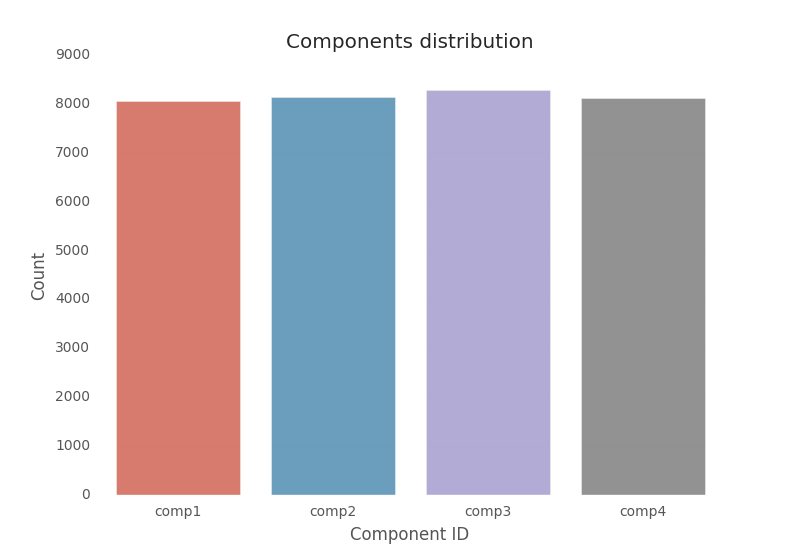

In [15]:
fig, ax = plt.subplots() 
components_count = (spark.createDataFrame(maint.groupBy('comp').count().collect())
              .toPandas())
sns.barplot(components_count['comp'], components_count['count'], alpha=0.8).set_title('Components distribution')
ax.set_ylabel("Count")
ax.set_xlabel("Component ID")
display(ax.figure)

### Telemetry data set

The telemetry time-series data consists of voltage, rotation, pressure, and vibration sensor measurements collected from each  machines in real time. The data is averaged over an hour and stored in the telemetry logs.

In [17]:
telemetry =  spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load(os.path.join(storage_path, csv_files_names['telemetry']))

# handle missing values
# define groups of features 
telemetry_cols = telemetry.columns

features_datetime = ['datetime']
features_categorical = ['machineID']
features_numeric = list(set(telemetry_cols) - set(features_datetime) - set(features_categorical))

# Replace numeric NA with 0
telemetry = telemetry.fillna(0, subset = features_numeric)

# Replace categorical NA with 'Unknown'
telemetry = telemetry.fillna("Unknown", subset = features_categorical)

# Counts...
print(telemetry.count())

# Examine 10 rows of data.
display(telemetry.take(10))

datetime,machineID,volt,rotate,pressure,vibration
2015-01-01T06:00:00.000+0000,1,151.919998705647,530.813577555042,101.788175260076,49.6040134898504
2015-01-01T07:00:00.000+0000,1,174.522001096471,535.523532319384,113.256009499254,41.5159054753218
2015-01-01T08:00:00.000+0000,1,146.912821646066,456.080746005808,107.786964633461,42.0996936545816
2015-01-01T09:00:00.000+0000,1,179.530560852404,503.469990485512,108.283817221771,37.8477274946112
2015-01-01T10:00:00.000+0000,1,180.544276621327,371.600611295334,107.55330679883,41.4678800376109
2015-01-01T11:00:00.000+0000,1,141.41175703074,530.857266087542,87.6140012779218,44.9858461978707
2015-01-01T12:00:00.000+0000,1,184.083821743344,450.2275288129,87.6973797069792,30.8312627133489
2015-01-01T13:00:00.000+0000,1,166.632618417563,486.466837788584,108.067733800301,50.3800539242367
2015-01-01T14:00:00.000+0000,1,159.892748369181,488.968697483274,102.131884360457,43.661296546187
2015-01-01T15:00:00.000+0000,1,176.686811672085,508.202759433056,90.9511892146129,43.039695633682


Rather than plot 8.7 million data points, The figure shows one month worth of telemetry sensor data for one machine.

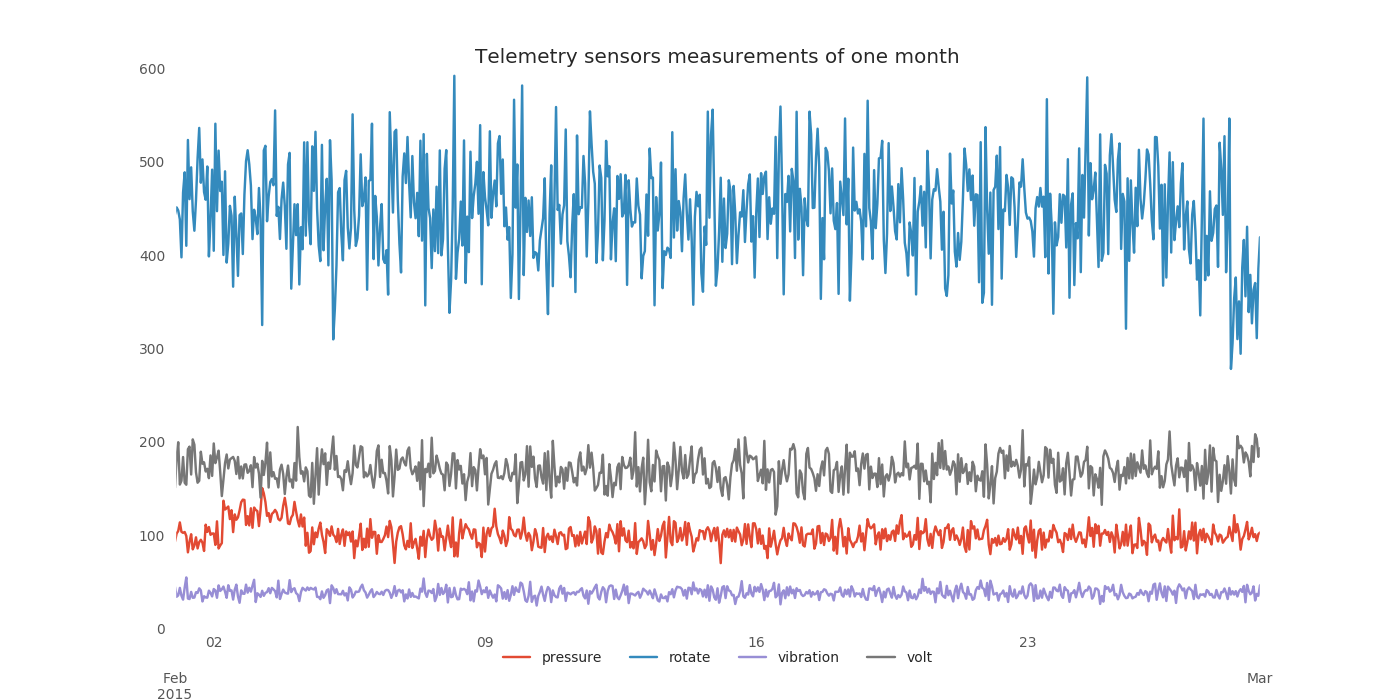

In [19]:
plt_data = telemetry.filter(telemetry.machineID == 1).toPandas()

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")


# Quick plot to show structure
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

fig, ax = plt.subplots(figsize=(14,7))
plt_data.groupby(['datetime','variable']).mean()['value']\
    .unstack().plot(ax=ax, title = 'Telemetry sensors measurements of one month')
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.05),ncol= 4,
         fancybox=True, shadow=True)
display(fig)

### Failures data set

Failures correspond to component replacements within the maintenance log. Each record contains the Machine ID, component type, and replacement datetime. These records will be used to create the machine learning labels we will be trying to predict.

In [21]:
failures =  spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load(os.path.join(storage_path,csv_files_names['failures']))
display(failures.take(5))

datetime,machineID,failure
2015-02-04T06:00:00.000+0000,1,comp3
2015-03-21T06:00:00.000+0000,1,comp1
2015-04-05T06:00:00.000+0000,1,comp4
2015-05-05T06:00:00.000+0000,1,comp3
2015-05-20T06:00:00.000+0000,1,comp2


d The following figure shows failure related replacements occured for each of the 4 component types over the entire year. of the failure records obtained from failure log. This log was built originally from component replacements the maintenance log file.

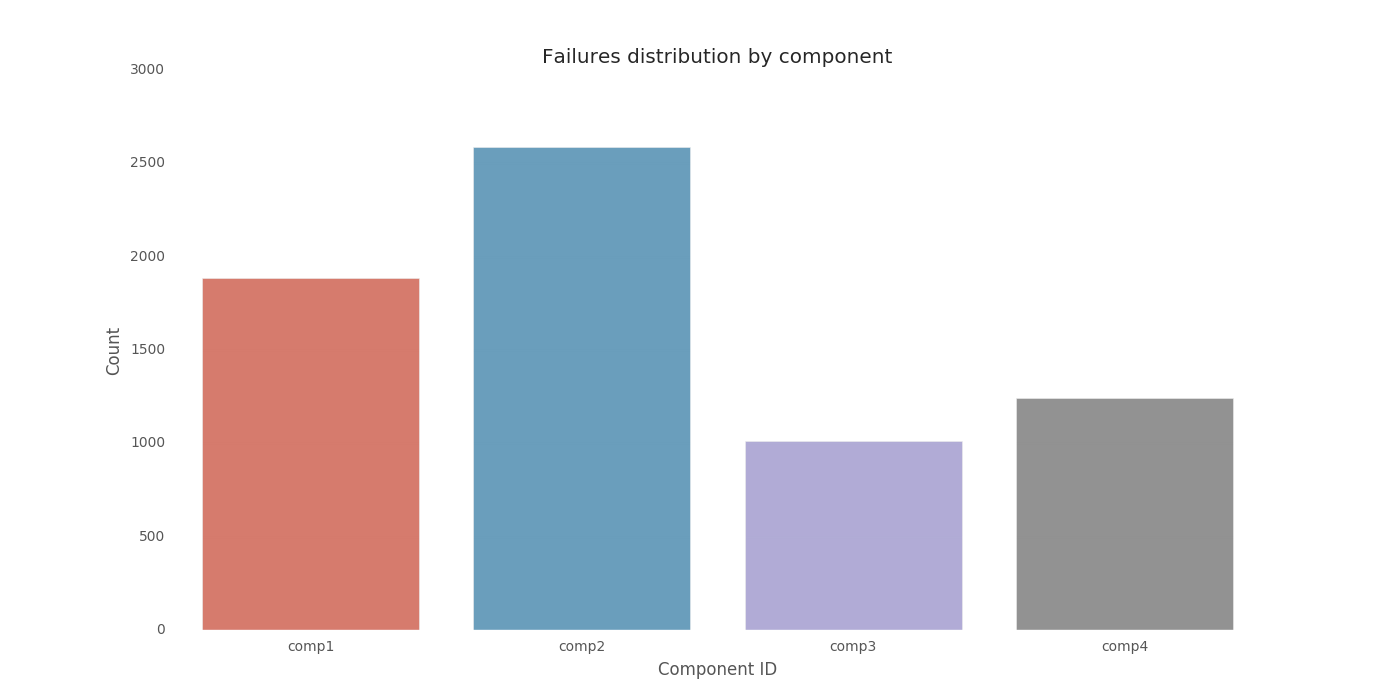

In [23]:
fig, ax = plt.subplots(figsize=(14,7)) 
failures_count = (spark.createDataFrame(failures.groupBy('failure').count().collect())
              .toPandas())
sns.barplot(failures_count['failure'], failures_count['count'], alpha=0.8).set_title('Failures distribution by component')
ax.set_ylabel("Count")
ax.set_xlabel("Component ID")
display(ax.figure)

Now we write the spark dataframes to disk as parquet files.

In [25]:
machines.write.mode('overwrite').parquet(os.path.join(target_dir,parquet_files_names['machines']))
errors.write.mode('overwrite').parquet(os.path.join(target_dir,parquet_files_names['errors']))
maint.write.mode('overwrite').parquet(os.path.join(target_dir,parquet_files_names['maint']))
telemetry.write.mode('overwrite').parquet(os.path.join(target_dir,parquet_files_names['telemetry']))
failures.write.mode('overwrite').parquet(os.path.join(target_dir,parquet_files_names['failures']))

for key, val in csv_files_names.items():
  dbutils.fs.rm(os.path.join(target_dir, csv_files_names[key]))

toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))

Full run took 3.54 minutes

## Conclusion

We have now downloaded the required data files in csv format. We have perormed exploratory analysis on diffrenet dimension of the data sets. Then saved them as Spark data frames for use in the remaining analysis steps. The `Code\2_feature_engineering.ipynb` Jupyter notebook will read these spark data frames and generate the modeling features for out predictive maintenance machine learning model.